In [4]:
%load_ext autoreload
%autoreload 2

In [39]:
import os
import sys

import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

import seaborn as sns

from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

# Evaluation Pipeline

## Fitness Function

### Beale Function

In [25]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [26]:
xmin, xmax, xstep = -4.5, 4.5, 0.2
ymin, ymax, ystep = -4.5, 4.5, 0.2

X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep),
                   np.arange(ymin, ymax + ystep, ystep))

Z = f(X, Y)

In [27]:
minima = np.array([3.0, 0.5])

f(*minima)

0.0

In [29]:
f(*minima_)

array([0.])

In [28]:
minima_ = minima.reshape(-1, 1)
minima_

array([[3. ],
       [0.5]])

In [251]:
X_0 = np.array([3.0, 4.0])

### Goldstein-Price Function 

In [253]:
def f(x, y):
    z_1 = (1 + ((x+y+1)**2) * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2))
    z_2 = (30 + ((2*x - 3*y)**2) * (18 - 32*x + (12*x**2) + 48*y - 36*x*y + (27*y**2)))
    return z_1 * z_2

In [254]:
xmin, xmax, xstep = -2.5, 3.0, 0.1
ymin, ymax, ystep = -3.0, 2.5, 0.1

# flip X and Y for better viz
X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep),
                   np.arange(ymin, ymax + ystep, ystep))

Z = f(X, Y)

In [255]:
minima = np.array([0.0, -1.0])

f(*minima)

3.0

In [256]:
minima_ = minima.reshape(-1, 1)
minima_

array([[ 0.],
       [-1.]])

In [271]:
X_0 = np.array([-2.0, 2.0])

## 3D Surface Plot 

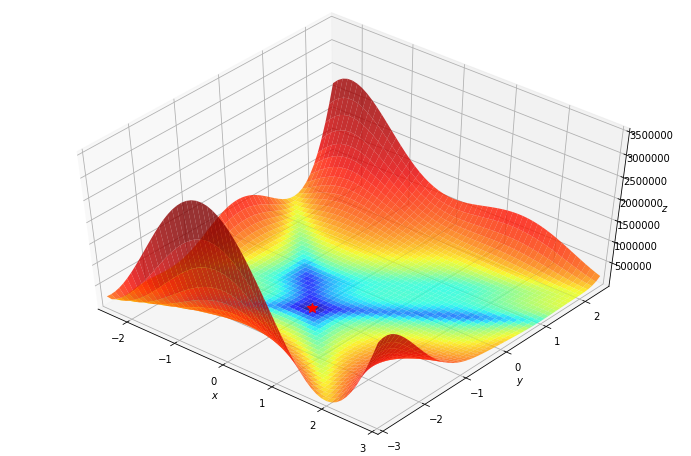

In [272]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(X, Y, Z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

## 2D Gradient Vector Field 

In [273]:
δz_δx = elementwise_grad(f, argnum=0)(X, Y)
δz_δy = elementwise_grad(f, argnum=1)(X, Y)

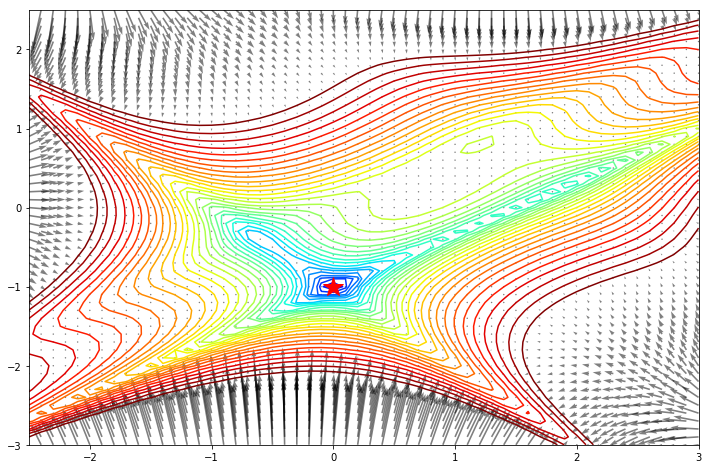

In [274]:
fig, axes = plt.subplots(figsize=(12, 8))

axes.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
axes.quiver(X, Y, X - δz_δx, Y - δz_δy, alpha=0.5)
axes.plot(*minima_, 'r*', markersize=20)

plt.show()

## Gradient-based Optimisation 

In [289]:
func = value_and_grad(lambda args: f(*args))

In [290]:
results = minimize(func, x0=X_0, method='Newton-CG', jac=True, tol=None, callback=print)

[-2.20148593  1.04935942]
[-2.1204587   1.10517923]
[-1.53780639  0.51751201]
[-1.15678148  0.12936609]
[-0.91260753 -0.12395578]
[-0.76197912 -0.27876442]
[-0.66830035 -0.35151878]
[-0.61559965 -0.3865574 ]
[-0.60119629 -0.39882083]
[-0.60000926 -0.39999074]
[-0.6 -0.4]


In [291]:
results

     fun: 30.0
     jac: array([-0.00333541,  0.00499784])
 message: 'Optimization terminated successfully.'
    nfev: 12
    nhev: 0
     nit: 11
    njev: 64
  status: 0
 success: True
       x: array([-0.6, -0.4])

In [292]:
def make_minimize_callback(path=[]):
    def minimize_callback(X_i):
        path.append(np.copy(X_i))
        
    return minimize_callback

In [293]:
path_ = [X_0]

results = minimize(func, x0=X_0, method='Newton-CG',
                   jac=True, tol=1e-20, callback=make_minimize_callback(path_))

In [294]:
results

     fun: 30.0
     jac: array([-3.06133838e-08, -3.49144633e-08])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 14
    nhev: 0
     nit: 12
    njev: 83
  status: 2
 success: False
       x: array([-0.6, -0.4])

In [295]:
path = np.array(path_).T
path.shape

(2, 13)

In [296]:
path

array([[-2.        , -2.20148593, -2.1204587 , -1.53780639, -1.15678148,
        -0.91260753, -0.76197912, -0.66830035, -0.61559965, -0.60119629,
        -0.60000926, -0.6       , -0.6       ],
       [ 2.        ,  1.04935942,  1.10517923,  0.51751201,  0.12936609,
        -0.12395578, -0.27876442, -0.35151878, -0.3865574 , -0.39882083,
        -0.39999074, -0.4       , -0.4       ]])

## Static Quiver Plot of Path on 2D Contour Plot 

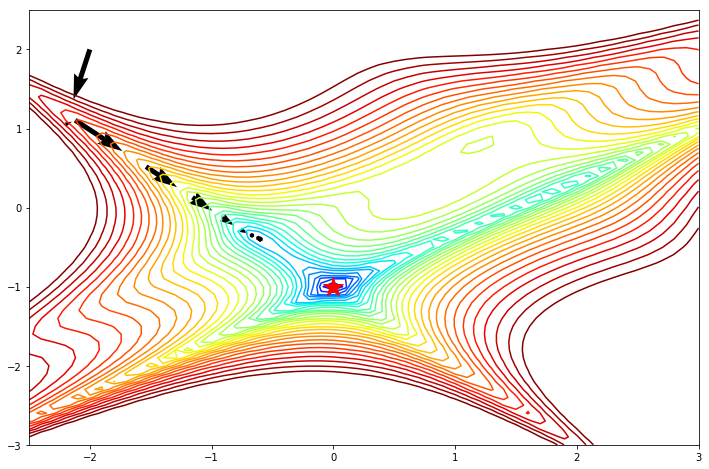

In [297]:
fig, axes = plt.subplots(figsize=(12, 8))

axes.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
axes.quiver(path[0, :-1], path[1, :-1], path[0, 1:] - path[0, :-1], path[1, 1:] - path[1, :-1],
            scale_units='xy', angles='xy', scale=1.5, color='k')
axes.plot(*minima_, 'r*', markersize=20)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

## Static Plot of Path on 3D Surface Plot 

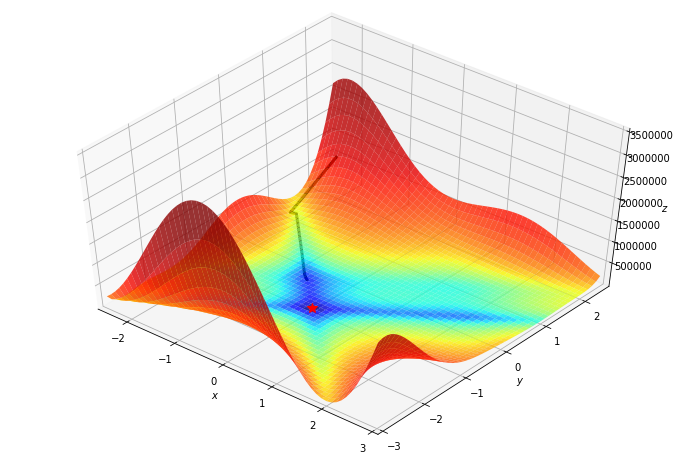

In [298]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(X, Y, Z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.plot_wireframe(path[0, :-1], path[1, :-1], f(*path[:, :-1]), linewidths=3, colors='k')

ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

## Animated Single Path on 2D Contour Plot 

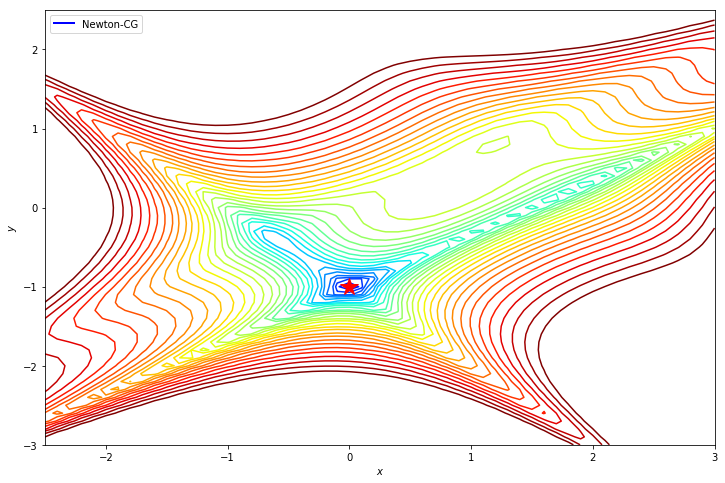

In [299]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')
plt.show()

In [300]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(*path[:, :i])
    point.set_data(*path[:, i-1:i])
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, repeat_delay=5, blit=True)

In [301]:
HTML(anim.to_html5_video())

## Animated Single Path on 3D Surface Plot 

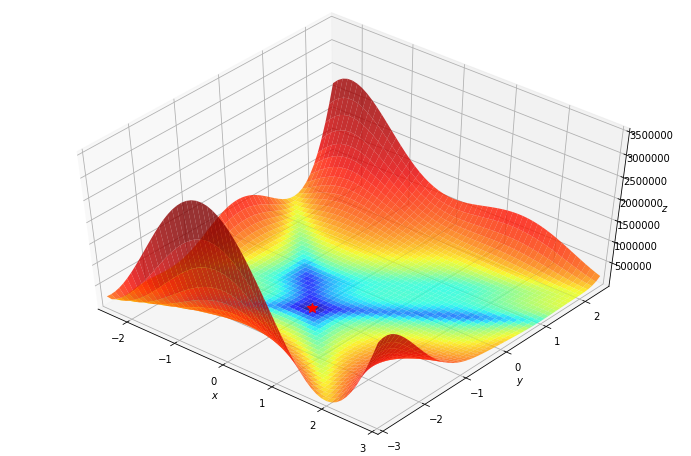

In [302]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(X, Y, Z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

line, = ax.plot([], [], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [303]:
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

def animate(i):
    line.set_data(path[0, :i], path[1, :i])
    line.set_3d_properties(f(*path[:, :i]))
    point.set_data(path[0, i-1:i], path[1, i-1:i])
    point.set_3d_properties(f(*path[:, i-1:i]))
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, repeat_delay=5, blit=True)

In [304]:
HTML(anim.to_html5_video())